## Heeger & Bergen Texture Synthesis Algorithms

The Heeger & Bergen (HB) texture synthesis algorithm is a method used to generate realistic textures. It typically involves analyzing the statistical properties of a given texture and then using this information to synthesize new textures with similar characteristics. 

# Import required libraries

In [39]:
import numpy as np
import os
import copy
import matplotlib.pyplot as plt

## Q1.1 Given an image, contruct it's steerable pyramids representation

A steerable pyramid is a multi-resolution image representation that can be efficiently computed and analyzed. It is particularly useful for capturing and decomposing image information at different scales and orientations. The construction of a steerable pyramid involves applying a series of filtering and downsampling operations, often using filters that are steerable in different directions.

For $P$ scales, and $Q$ orientations of an image, a steerable pyramid representation has a total of $PQ + 2$ filters.

In [32]:
from scipy.special import factorial
import math
from pyrtools.pyramids.c.wrapper import pointOp


def rcosFn(width=1, position=0, values=(0, 1)):
    sz = 256   # arbitrary!
    X = np.pi * np.arange(-sz - 1, 2) / (2 * sz)
    Y = values[0] + (values[1] - values[0]) * np.cos(X) ** 2
    Y[0] = Y[1]
    Y[sz + 2] = Y[sz + 1]
    X = position + (2 * width / np.pi) * (X + np.pi / 4)
    return (X, Y)


def steerable_pyramid_representation(image, P, Q):
    """
    Computes the steerable pyramid representation of an image.

    Parameters:
    - image: 2D array, input image
    - P: int, number of scales
    - Q: int, number of orientations

    Returns:
    - pyr_coeffs: dictionary, coefficients of the steerable pyramid
    - pyr_sizes: dictionary, sizes of the pyramid levels
    """

    # Initialize dictionaries to store pyramid coefficients and sizes
    pyr_coeffs = {}
    pyr_sizes = {}
    
    # Number of scales and orientations
    num_scales = P
    num_orientations = Q + 1

    # Width of the transition function
    twidth = 1
    
    # Dimensions of the input image
    dims = np.array(image.shape)
    
    # Center of the image
    ctr = np.ceil((np.array(dims) + 0.5) / 2).astype(int)

    # Create coordinate grids
    (xramp, yramp) = np.meshgrid(np.linspace(-1, 1, dims[1]+1)[:-1],
                                 np.linspace(-1, 1, dims[0]+1)[:-1])

    # Compute angle and log-polar coordinates
    angle = np.arctan2(yramp, xramp)
    log_rad = np.sqrt(xramp ** 2 + yramp ** 2)
    log_rad[ctr[0] - 1, ctr[1] - 1] = log_rad[ctr[0] - 1, ctr[1] - 2]
    log_rad = np.log2(log_rad)

    # Radial transition function (a raised cosine in log-frequency)
    (Xrcos, Yrcos) = rcosFn(twidth, (-twidth / 2.0), np.array([0, 1]))
    Yrcos = np.sqrt(Yrcos)
    YIrcos = np.sqrt(1.0 - Yrcos**2)
    lo0mask = pointOp(log_rad, YIrcos, Xrcos[0], Xrcos[1]-Xrcos[0])

    # Compute the Fourier transform of the input image
    imdft = np.fft.fftshift(np.fft.fft2(image))

    # High-pass filter the image
    hi0mask = pointOp(log_rad, Yrcos, Xrcos[0], Xrcos[1] - Xrcos[0])
    hi0dft = imdft * hi0mask.reshape(imdft.shape[0], imdft.shape[1])
    hi0 = np.fft.ifft2(np.fft.ifftshift(hi0dft))

    # Store the high-pass residual
    pyr_coeffs['residual_highpass'] = np.real(hi0)
    pyr_sizes['residual_highpass'] = hi0.shape

    # Low-pass filter the image
    lo0mask = lo0mask.reshape(imdft.shape[0], imdft.shape[1])
    lodft = imdft * lo0mask

    # Iterate over scales
    for i in range(num_scales):
        Xrcos -= np.log2(2)

        # Generate lookup table for cosine values
        lutsize = 1024
        Xcosn = np.pi * np.arange(-(2 * lutsize + 1), (lutsize + 2)) / lutsize

        # Compute steerable filters' coefficients
        const = (2 **( 2 * Q)) * (factorial(Q, exact=True) ** 2)/ float(num_orientations * factorial(2 * Q, exact=True))
        Ycosn = np.sqrt(const) * (np.cos(Xcosn)) ** Q

        # Compute the frequency masks
        log_rad_test = np.reshape(log_rad, (1, log_rad.shape[0] * log_rad.shape[1]))
        himask = pointOp(log_rad_test, Yrcos, Xrcos[0], Xrcos[1]-Xrcos[0])
        himask = himask.reshape((lodft.shape[0], lodft.shape[1]))

        # Compute angle masks
        anglemasks = []
        for b in range(num_orientations):
            angle_tmp = np.reshape(angle, (1, angle.shape[0] * angle.shape[1]))
            anglemask = pointOp(angle_tmp, Ycosn, Xcosn[0] + np.pi * b / num_orientations, Xcosn[1] - Xcosn[0])

            anglemask = anglemask.reshape(lodft.shape[0], lodft.shape[1])
            anglemasks.append(anglemask)

            # Compute bandpass filter in the Fourier domain
            banddft = (-1j) ** Q * lodft * anglemask * himask
            band = np.fft.ifft2(np.fft.ifftshift(banddft))

            # Store the bandpass coefficients
            pyr_coeffs[(i, b)] = np.real(band.copy())
            pyr_sizes[(i, b)] = band.shape

        # Update dimensions for the next scale
        dims = np.array(lodft.shape)
        ctr = np.ceil((dims+0.5)/2).astype(int)
        lodims = np.ceil((dims-0.5)/2).astype(int)
        loctr = np.ceil((lodims+0.5)/2).astype(int)
        lostart = ctr - loctr
        loend = lostart + lodims

        # Update log_rad, angle, and lodft for the next scale
        log_rad = log_rad[lostart[0]:loend[0], lostart[1]:loend[1]]
        angle = angle[lostart[0]:loend[0], lostart[1]:loend[1]]
        lodft = lodft[lostart[0]:loend[0], lostart[1]:loend[1]]

        # Update low-pass masks
        YIrcos = np.abs(np.sqrt(1.0 - Yrcos**2))
        log_rad_tmp = np.reshape(log_rad, (1, log_rad.shape[0] * log_rad.shape[1]))
        lomask = pointOp(log_rad_tmp, YIrcos, Xrcos[0], Xrcos[1]-Xrcos[0])
        lomask = lomask.reshape(lodft.shape[0], lodft.shape[1])

        lodft = lodft * lomask

    # Inverse Fourier transform of the final low-pass residual
    lodft = np.fft.ifft2(np.fft.ifftshift(lodft))

    # Store the final low-pass residual coefficients
    pyr_coeffs['residual_lowpass'] = np.real(np.array(lodft).copy())
    pyr_sizes['residual_lowpass'] = lodft.shape

    return pyr_coeffs, pyr_sizes

import cv2
image = cv2.cvtColor(cv2.imread("test/paper3.png"), cv2.COLOR_BGR2GRAY)
P = 3
Q = 4
pyr_1 = pt.pyramids.SteerablePyramidFreq(image, P, Q)
pyr_2 = steerable_pyramid_representation(image, P, Q)

In [33]:
pyr_1._recon_keys(levels='all', bands='all')

['residual_highpass',
 (0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 'residual_lowpass']

In [34]:
list(pyr_2[0].keys())

['residual_highpass',
 (0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 'residual_lowpass']

## Q1.2 Given a steerable pyramid representation of an image, reconstruct the image

In [36]:
def reconstruct_image(pyr_coeffs, pyr_sizes):
        
    recon_keys = list(pyr_coeffs.keys())

    P = max([key[0] for key in recon_keys if type(key) is tuple]) + 1
    Q = max([key[1] for key in recon_keys if type(key) is tuple])
    num_scales = P
    num_orientations = Q + 1

    # make list of dims and bounds
    bound_list = []
    dim_list = []
    # we go through pyr_sizes from smallest to largest
    for dims in sorted(pyr_sizes.values()):
        if dims in dim_list:
            continue
        dim_list.append(dims)
        dims = np.array(dims)
        ctr = np.ceil((dims+0.5)/2).astype(int)
        lodims = np.ceil((dims-0.5)/2).astype(int)
        loctr = np.ceil((lodims+0.5)/2).astype(int)
        lostart = ctr - loctr
        loend = lostart + lodims
        bounds = (lostart[0], lostart[1], loend[0], loend[1])
        bound_list.append(bounds)
    bound_list.append((0, 0, dim_list[-1][0], dim_list[-1][1]))
    dim_list.append((dim_list[-1][0], dim_list[-1][1]))

    # matlab code starts here
    dims = np.array(pyr_sizes['residual_highpass'])
    ctr = np.ceil((dims+0.5)/2.0).astype(int)

    (xramp, yramp) = np.meshgrid((np.arange(1, dims[1]+1)-ctr[1]) / (dims[1]/2.),
                                 (np.arange(1, dims[0]+1)-ctr[0]) / (dims[0]/2.))
    angle = np.arctan2(yramp, xramp)
    log_rad = np.sqrt(xramp**2 + yramp**2)
    log_rad[ctr[0]-1, ctr[1]-1] = log_rad[ctr[0]-1, ctr[1]-2]
    log_rad = np.log2(log_rad)

    # Radial transition function (a raised cosine in log-frequency):
    (Xrcos, Yrcos) = rcosFn(1, (-1/2.0), np.array([0, 1]))
    Yrcos = np.sqrt(Yrcos)
    YIrcos = np.sqrt(1.0 - Yrcos**2)

    # from reconSFpyrLevs
    lutsize = 1024

    Xcosn = np.pi * np.arange(-(2*lutsize+1), (lutsize+2)) / lutsize

    const = (2**(2*Q))*(factorial(Q, exact=True)**2) / float(num_orientations*factorial(2*Q, exact=True))
    Ycosn = np.sqrt(const) * (np.cos(Xcosn))**Q

    # lowest band
    # initialize reconstruction
    if 'residual_lowpass' in recon_keys:
        nresdft = np.fft.fftshift(np.fft.fft2(pyr_coeffs['residual_lowpass']))
    else:
        nresdft = np.zeros_like(pyr_coeffs['residual_lowpass'])
    resdft = np.zeros(dim_list[1]) + 0j

    bounds = (0, 0, 0, 0)
    for idx in range(len(bound_list)-2, 0, -1):
        diff = (bound_list[idx][2]-bound_list[idx][0],
                bound_list[idx][3]-bound_list[idx][1])
        bounds = (bounds[0]+bound_list[idx][0], bounds[1]+bound_list[idx][1],
                  bounds[0]+bound_list[idx][0] + diff[0],
                  bounds[1]+bound_list[idx][1] + diff[1])
        Xrcos -= np.log2(2.0)
    nlog_rad = log_rad[bounds[0]:bounds[2], bounds[1]:bounds[3]]

    nlog_rad_tmp = np.reshape(nlog_rad, (1, nlog_rad.shape[0]*nlog_rad.shape[1]))
    lomask = pointOp(nlog_rad_tmp, YIrcos, Xrcos[0], Xrcos[1]-Xrcos[0])
    lomask = lomask.reshape(nresdft.shape[0], nresdft.shape[1])
    lomask = lomask + 0j
    resdft[bound_list[1][0]:bound_list[1][2],
           bound_list[1][1]:bound_list[1][3]] = nresdft * lomask

    # middle bands
    for idx in range(1, len(bound_list)-1):
        bounds1 = (0, 0, 0, 0)
        bounds2 = (0, 0, 0, 0)
        for boundIdx in range(len(bound_list) - 1, idx - 1, -1):
            diff = (bound_list[boundIdx][2]-bound_list[boundIdx][0],
                    bound_list[boundIdx][3]-bound_list[boundIdx][1])
            bound2tmp = bounds2
            bounds2 = (bounds2[0]+bound_list[boundIdx][0],
                       bounds2[1]+bound_list[boundIdx][1],
                       bounds2[0]+bound_list[boundIdx][0] + diff[0],
                       bounds2[1]+bound_list[boundIdx][1] + diff[1])
            bounds1 = bound2tmp
        nlog_rad1 = log_rad[bounds1[0]:bounds1[2], bounds1[1]:bounds1[3]]
        nlog_rad2 = log_rad[bounds2[0]:bounds2[2], bounds2[1]:bounds2[3]]
        dims = dim_list[idx]
        nangle = angle[bounds1[0]:bounds1[2], bounds1[1]:bounds1[3]]
        YIrcos = np.abs(np.sqrt(1.0 - Yrcos**2))
        if idx > 1:
            Xrcos += np.log2(2.0)
            nlog_rad2_tmp = np.reshape(nlog_rad2, (1, nlog_rad2.shape[0]*nlog_rad2.shape[1]))
            lomask = pointOp(nlog_rad2_tmp, YIrcos, Xrcos[0],
                             Xrcos[1]-Xrcos[0])
            lomask = lomask.reshape(bounds2[2]-bounds2[0],
                                    bounds2[3]-bounds2[1])
            lomask = lomask + 0j
            nresdft = np.zeros(dim_list[idx]) + 0j
            nresdft[bound_list[idx][0]:bound_list[idx][2],
                    bound_list[idx][1]:bound_list[idx][3]] = resdft * lomask
            resdft = nresdft.copy()

        # reconSFpyrLevs
        if idx != 0 and idx != len(bound_list)-1:
            for b in range(num_orientations):
                nlog_rad1_tmp = np.reshape(nlog_rad1,
                                           (1, nlog_rad1.shape[0]*nlog_rad1.shape[1]))
                himask = pointOp(nlog_rad1_tmp, Yrcos, Xrcos[0], Xrcos[1]-Xrcos[0])

                himask = himask.reshape(nlog_rad1.shape)
                nangle_tmp = np.reshape(nangle, (1, nangle.shape[0]*nangle.shape[1]))
                anglemask = pointOp(nangle_tmp, Ycosn,
                                    Xcosn[0]+np.pi*b/num_orientations,
                                    Xcosn[1]-Xcosn[0])

                anglemask = anglemask.reshape(nangle.shape)
                # either the coefficients will already be real-valued (if
                # self.is_complex=False) or complex (if self.is_complex=True). in the
                # former case, this np.real() does nothing. in the latter, we want to only
                # reconstruct with the real portion
                curLev = num_scales-1 - (idx-1)
                band = np.real(pyr_coeffs[(curLev, b)])
                if (curLev, b) in recon_keys:
                    banddft = np.fft.fftshift(np.fft.fft2(band))
                else:
                    banddft = np.zeros(band.shape)
                resdft += ((np.power(-1+0j, 0.5))**(num_orientations-1) *
                           banddft * anglemask * himask)

    # apply lo0mask
    Xrcos += np.log2(2.0)
    lo0mask = pointOp(log_rad, YIrcos, Xrcos[0], Xrcos[1]-Xrcos[0])

    lo0mask = lo0mask.reshape(dims[0], dims[1])
    resdft = resdft * lo0mask

    # residual highpass subband
    hi0mask = pointOp(log_rad, Yrcos, Xrcos[0], Xrcos[1]-Xrcos[0])

    hi0mask = hi0mask.reshape(resdft.shape[0], resdft.shape[1])
    hidft = np.fft.fftshift(np.fft.fft2(pyr_coeffs['residual_highpass']))
    resdft += hidft * hi0mask
    outresdft = np.real(np.fft.ifft2(np.fft.ifftshift(resdft)))
    return outresdft


## Q2. Histogram Matching Function

Histogram matching is used to adjust the color distribution of an image to match a specified histogram. The histogram of an image represents the frequency distribution of pixel intensities. The matching function is applied to transform the image's histogram to resemble a target histogram.

In [ ]:


def histogram_matching(v, u):
    # align u onto the histogram of v
    assert v.size == u.size
    L = u.size
    # get v indices in sorted order
    indices_v = np.unravel_index(np.argsort(v, axis=None), v.shape)
    # get u indices in sorted order
    indices_u = np.unravel_index(np.argsort(u, axis=None), u.shape)
    for k in range(L):
        row_u, col_u = indices_u[0][k], indices_u[1][k]
        row_v, col_v = indices_v[0][k], indices_v[1][k]
        u[row_u][col_u] = v[row_v][col_v]
    return u

## Q3. Histogram Matching Function for scaled images

When working with scaled images, the number of pixels in synthesized image and input texture image are not the same. Adapt the histogram matching function for scaled images.

In [40]:
def histogram_matching_scaled(v, u, width_scale, height_scale):
    # align u onto the histogram of v
    factor_scale = width_scale * height_scale
    assert v.size * factor_scale == u.size
    L = v.size
    # get v indices in sorted order
    indices_v = np.unravel_index(np.argsort(v, axis=None), v.shape)
    # get u indices in sorted order
    indices_u = np.unravel_index(np.argsort(u, axis=None), u.shape)
    for k in range(L):
        # assign k * factor_scale to k * factor_scale + factor_scale
        row_v, col_v = indices_v[0][k], indices_v[1][k]
        for _ in range(k * factor_scale, k * factor_scale + factor_scale):
            row_u, col_u = indices_u[0][_], indices_u[1][_]
            u[row_u][col_u] = v[row_v][col_v]
    return u

## Q4. HB Texture Synthesis Algorithm

Put all the pieces together and complete the HB texture synthesis algorithm

In [41]:
def heeger_bergen_texture_synthesis(texture, P, Q, Niter, width_scale=1, height_scale=1):
    # Input analysis
    pyramid_texture = steerable_pyramid_representation(texture, P, Q)
    # Output synthesis
    texture_synth = np.random.normal(size=(texture.shape[0] * height_scale, texture.shape[1] * width_scale))  # Initialize v with Gaussian white noise
    print(texture.shape, texture_synth.shape)
    # Match the gray-level histogram of v with u
    texture_synth = histogram_matching_scaled(texture, texture_synth, width_scale=width_scale, height_scale=height_scale)
    for i in range(Niter):
        # Compute the steerable pyramid of v
        pyramid_texture_synth = steerable_pyramid_representation(texture_synth, P, Q)
        # Apply histogram matching for each image in the pyramid
        for pq_key in pyramid_texture_synth.pyr_coeffs:
            matched_image = histogram_matching_scaled(pyramid_texture.pyr_coeffs[pq_key], pyramid_texture_synth.pyr_coeffs[pq_key], width_scale=width_scale, height_scale=height_scale)
            pyramid_texture_synth.pyr_coeffs[pq_key] = copy.deepcopy(matched_image)
        # Apply image reconstruction algorithm
        texture_synth = reconstruct_image(pyramid_texture_synth)
        # Match the gray-level histogram of v with u
        texture_synth = histogram_matching_scaled(texture, texture_synth, width_scale=width_scale, height_scale=height_scale)
    return texture_synth

## Q5. Extend HB Texture Synthesis to Color Space

The above functions are defined for gray scale images. How to extend to color spaces ? Can we run texture synthesis on each color independently and combine the results ? Why or What not ?

In [44]:
import numpy as np
from sklearn.decomposition import PCA
import cv2

# Step 1: Load and preprocess the image
image_path = 'test/paper3.png'
original_image = cv2.imread(image_path)

def heeger_bergen_texture_synthesis_color(image):
    # Step 2: Convert RGB to PCA Color Space
    # Reshape the image to a 2D array (pixels as rows, color channels as columns)
    pixels = original_image.reshape((-1, 3))
    
    # Perform PCA
    num_components = 3  # Number of principal components to retain
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(pixels)
    
    # Step 3: Determine Channels in PCA Color Space
    # The channels in the PCA color space are the transformed features along the principal components
    pca_channels = pca_result[:, :num_components]
    
    # Now, pca_channels contains the channels in the PCA color space
    pca_channels_synth = []
    for channel in range(3):
        pca_channels_synth.append(heeger_bergen_texture_synthesis(pca_channels[:, channel].reshape(*original_image.shape[:2]), P, Q, Niter))
    pca_channels_synth = np.array(pca_channels_synth).transpose(1, 2, 0)
    
    texture_synth = np.zeros(original_image.shape)
    
    for i in range(texture_synth.shape[0]):
        for j in range(texture_synth.shape[1]):
            texture_synth[i, j, :] = pca.mean_ + pca.components_ @ pca_channels_synth[i, j, :]

Color channels are correlated. Perform PCA on the color channels, identify the most signficiant component, do a HB texture synthesis and map it back to color space.

## Q6. Edge Blending - Mirror Symmetrization

In [ ]:
width, height = original_image.shape[:2]
data_mirror = np.zeros((2 * height, 2 * width))

image = original_image[:, :, 0]

for i in range(width):
    for j in range(height):
        data_mirror[j][i] = image[j][i]
        data_mirror[j][i + width ] = image[j][width - 1 - i]
        data_mirror[height + j][i] = image[height - j - 1][i]
        data_mirror[height + j][i + height] = image[height - j - 1][width - i - 1]

pyramid_texture = steerable_pyramid(image, P, Q)
pyramid_texture_mirror = steerable_pyramid(data_mirror, P, Q)
for pq_key in pyramid_texture_mirror.pyr_coeffs:
    sub_band_height, sub_band_width = pyramid_texture_mirror.pyr_coeffs[pq_key].shape
    pyramid_texture.pyr_coeffs[pq_key] = pyramid_texture_mirror.pyr_coeffs[pq_key][:sub_band_height // 2, :sub_band_width // 2]
texture_input = image_reconstruction(pyramid_texture)
P = 3
Q = 3
Niter = 10
texture_synth = heeger_bergen_texture_synthesis(texture_input, P, Q, Niter)
plt.imshow(texture_synth)

## Q7. Edge Blending - Periodic Component

In [45]:
import cv2
import numpy as np
image = cv2.imread('/Users/harsha/Documents/courses/cs283/CS283/test/paper3.png')
image = image[:, :, 0]
image.shape

# Compute the Laplacian using the cv2.Laplacian function
image_laplacian = cv2.Laplacian(image, cv2.CV_64F)
image_laplacian_dft = np.fft.fft2(image_laplacian)
image_laplacian_dft.shape


def compute_p_hat(image, image_laplacian):
    """
    Compute the function p_hat for given parameters.

    Parameters:
    - M, N: Size of the 2D grid.
    - omega: Set of excluded coordinates (m, n) as a list of tuples.
    - uk: 2D array representing the input grid.

    Returns:
    - p_hat: Resulting 2D array.
    """
    M, N = image.shape
    p_hat = np.zeros((M, N), dtype=complex)
    for m in range(M):
        for n in range(N):
            if m != 0 or n != 0:
                # Compute p_hat for (m, n) not in omega
                p_hat[m, n] = image_laplacian[m, n] / (4 - 2 * np.cos(2 * np.pi * m / M) - 2 * np.cos(2 * np.pi * n / N))
    p_hat[0, 0] = np.sum(image)
    return p_hat

image_laplacian_inverse = compute_p_hat(image, image_laplacian)
periodic_component = np.fft.ifft2(image_laplacian_inverse)

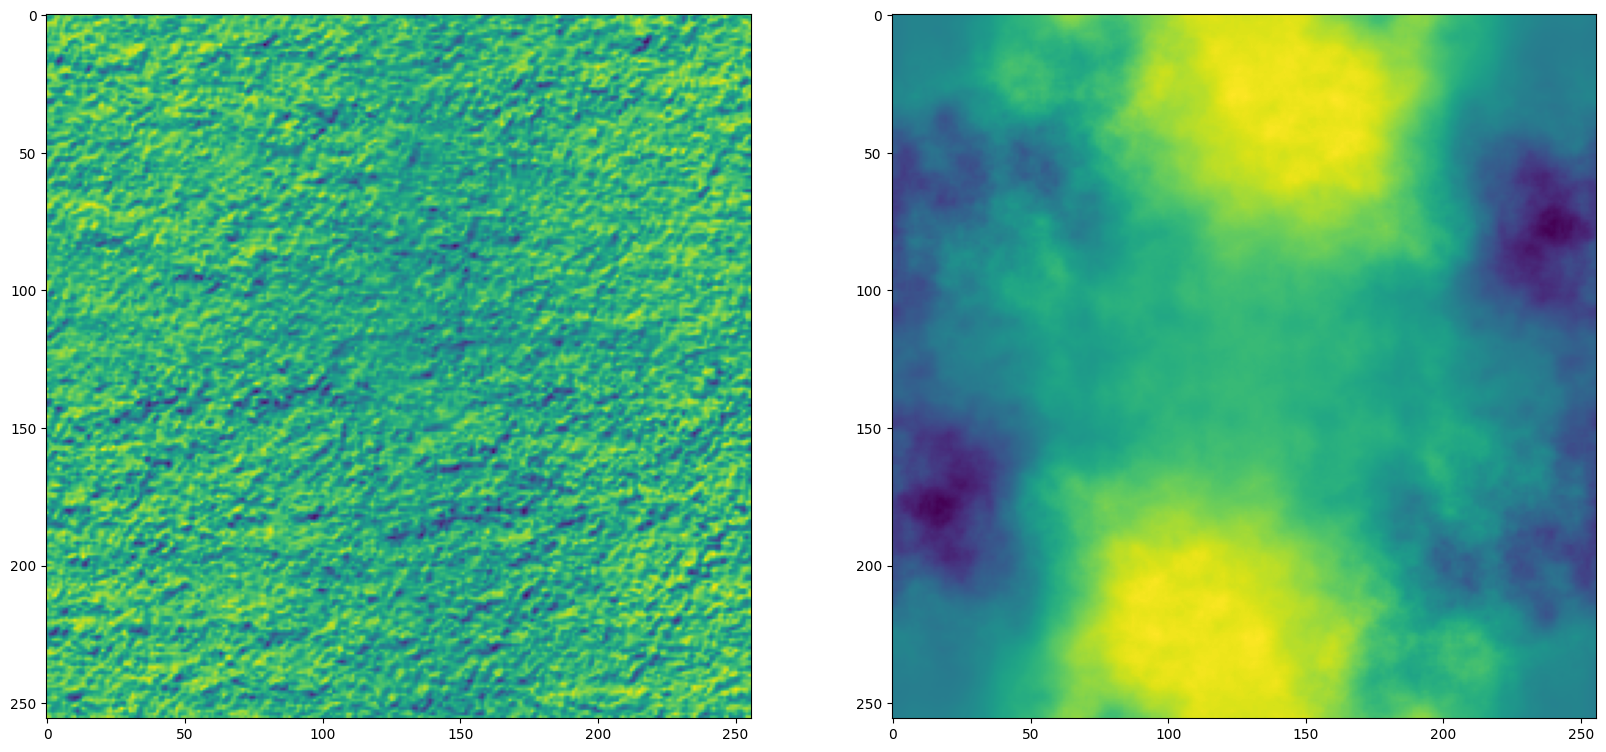

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[1].imshow(periodic_component.real)